###雲の画像から今後の天気を予測するAI

雲は10種類あり、そのうち雨雲と呼ばれる雲は2種類あります。webアプリなどにすることを考え、ユーザーが撮った写真に対してそれが雨雲か否かどうか判別するようにしました。(最初は10種類雲の種類を判別するAIを作っていたのですが、スクレイピングで得られる画像の数に限りがあり、精度があまり向上しなかったので2値分類に切り替えました。)

流れは以下のようになっています。

1. Bingの検索結果をスクレイピングして10種類の雲の画像を取得する
2. 雨雲とそれ以外に分け、教師データと評価データを用意する
3. CNNを用いて学習させる
4. ユーザーがアップロードした写真から、この後雨になるのか晴れになるのか予測する


###1. Bingの検索結果をスクレイピングして10種類の雲の画像を取得する

In [ ]:
!pip install bing-image-downloader
from google.colab import drive
drive.mount('/content/drive')
clouds = ['Cumulus', 'Stratus', 'Stratocumulus', 'Altocumulus', 'Nimbostratus', 'Altostratus', 'Cirrus', 'Cirrocumulus', 'Cirrostratus', 'Cumulonimbus']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


雨雲は2種類でそれ以外は8種類なので、不均衡データになるのを防ぐため、雨雲に関しては150枚取得する

In [ ]:
from bing_image_downloader import downloader
for cloud in clouds:
  if cloud =='Cumulus' or cloud == 'Cumulonimbus':
    query_string = cloud+' cloud'
    downloader.download(query_string,output_dir=r"/content/drive/MyDrive",adult_filter_off=True,timeout=2,limit=125,verbose= True)
  else:
    query_string = cloud+' cloud'
    downloader.download(query_string,output_dir=r"/content/drive/MyDrive",adult_filter_off=True,timeout=2,limit=50,verbose= True)

[%] Downloading Images to /content/drive/MyDrive/Cumulus cloud


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from http://upload.wikimedia.org/wikipedia/commons/8/89/Cumulus_cloud.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.publicdomainpictures.net/pictures/300000/velka/cumulus-clouds-15545180491Gg.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/GoldenMedows.jpg/1200px-GoldenMedows.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://coclouds.com/wp-content/uploads/2012/07/single-fluffy-cumulus-cloud-sunny-day-2012-07-26.jpg
[%] File Downloaded !

[%] Downloading Image #5 from http://www.publicdomainpictures.net/pictures/120000/velka/cumulus-cloud-1428590128Abv.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://weather.ou.edu/~smglenn/cumulus.jpg
[%] File Downloaded !

[%] Downloading Image #7 from http://stockarch.com/files/17/08/flu

### 2. 雨雲とそれ以外に分け、教師データと評価データを用意する

In [ ]:
import numpy as np
import glob

from tensorflow.keras.utils import load_img, img_to_array

#ディレクトリ(path)名称
dir_name = '/content/drive/MyDrive'
#画像拡張子
file_type = 'jpg'
img_list = []
y = []
#不均衡化が避けられないため、考える雲の種類を限定する
clouds = ['Cumulus', 'Stratus', 'Stratocumulus', 'Altocumulus',  'Cirrus','Nimbostratus',  'Cumulonimbus']

for cloud in clouds:
  #glob.globで全画像のpath情報を取得する
  img_list_path = glob.glob(dir_name + '/' + cloud+' cloud/*.'+file_type) 
  #読み込んだ画像を格納する空のリストを作成
  img_shape = (256, 256, 3)
  #for文で1枚ずつpath情報を取り出して、それをload_imgで読み込んでいき、リストに格納していく
  for img in img_list_path:
      temp_img = load_img(img, grayscale=False, target_size=img_shape)#PIL形式で画像読み込み
      temp_img_array = img_to_array(temp_img) / 255 #PIL⇒配列化 + 255で割って正規化
      img_list.append(temp_img_array) #用意したリストに追加する
      if cloud == 'Cumulus' or cloud == 'Cumulonimbus' :
        y.append([0])
      else:
        y.append([1])
  #学習画像として、リストをさらに配列化して、(n, width, haight, ch)の形に変換
X = np.array(img_list)

In [ ]:
print(X.shape)
print(len(y))

(459, 256, 256, 3)
459


In [ ]:
u, counts = np.unique(y, return_counts=True)
print(counts)

[229 230]


In [ ]:
y = np.array(y)
print(X.shape)
print(y.shape)

(459, 256, 256, 3)
(459, 1)


画像を表示してみる

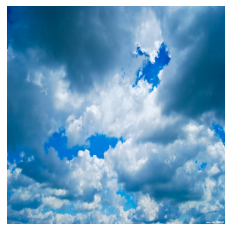

[0]


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

id =  40
plt.imshow(X[id])
ans = np.argmax(y[id])
plt.axis('off')
plt.show()
print(y[id])

分割する

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (367, 256, 256, 3)
367 train samples
92 test samples


In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

### 3. CNNを用いて学習させる

Data Augumentation

In [ ]:
import tensorflow as tf
# 与えられた画像に対し、様々な処理を加えて新しい画像を生成するためジェネレータを作成
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # 真理値．データセット全体で，入力の平均を0にします．
        samplewise_center=False,  # 真理値．各サンプルの平均を0にします．
        featurewise_std_normalization=False,  # 真理値．入力をデータセットの標準偏差で正規化します
        samplewise_std_normalization=False,  # 真理値．各入力をその標準偏差で正規化します．
        zca_whitening=False,  # 真理値．ZCA白色化を適用します．
        zca_epsilon=1e-06,  # ZCA白色化のイプシロン．デフォルトは1e-6
        rotation_range=20,  # 整数．画像をランダムに回転する回転範囲．
        width_shift_range=0.2, # 浮動小数点数（横幅に対する割合）．ランダムに水平シフトする範囲．
        height_shift_range=0.2, # 浮動小数点数（縦幅に対する割合）．ランダムに垂直シフトする範囲．
        shear_range=0.,  # 浮動小数点数．シアー強度（反時計回りのシアー角度）．
        zoom_range=0.,  # 浮動小数点数または[lower，upper]．ランダムにズームする範囲．浮動小数点数が与えられた場合，[lower, upper] = [1-zoom_range, 1+zoom_range]です．
        channel_shift_range=0.,  # 浮動小数点数．ランダムにチャンネルをシフトする範囲．
        fill_mode='nearest', # {"constant", "nearest", "reflect", "wrap"}のいずれか．デフォルトは 'nearest'です．指定されたモードに応じて，入力画像の境界周りを埋めます．
        cval=0.,  # 浮動小数点数または整数．fill_mode = "constant"のときに境界周辺で利用される値．
        horizontal_flip=True,  # 真理値．水平方向に入力をランダムに反転します．
        vertical_flip=False,  # 真理値．垂直方向に入力をランダムに反転します．
        rescale=None, # 画素値のリスケーリング係数．デフォルトはNone．Noneか0ならば，適用しない．それ以外であれば，(他の変換を行う前に) 与えられた値をデータに積算する．
        # set function that will be applied on each input
        preprocessing_function=None, # 各入力に適用される関数です．この関数は他の変更が行われる前に実行されます．この関数は3次元のNumpyテンソルを引数にとり，同じshapeのテンソルを出力するように定義する必要があります．
        data_format=None, # {"channels_first", "channels_last"}のどちらか．"channels_last"の場合，入力のshapeは(samples, height, width, channels)となり，"channels_first"の場合は(samples, channels, height, width)となります．デフォルトはKerasの設定ファイル~/.keras/keras.jsonのimage_data_formatの値です．一度も値を変更していなければ，"channels_last"になります．
        validation_split=0.0) # 浮動小数点数．検証のために予約しておく画像の割合（厳密には0から1の間）です．
#datagen.fit(x_train)

In [ ]:
model = tf.keras.Sequential()

# Convolution 1 フィルタ32枚、各フィルタのカーネルサイズ3x3 ストライドはデフォルト (1, 1)、パディングは`same`を指定。
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
# 'relu'で活性化
model.add(tf.keras.layers.Activation('relu'))

# Convolution 2 フィルタ32枚、各フィルタのカーネルサイズ3x3 ストライドはデフォルト (1, 1)
model.add(tf.keras.layers.Conv2D(32, (3, 3)))
# 'relu'で活性化
model.add(tf.keras.layers.Activation('relu'))

# Max Pooling 1 (size: 2x2)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# 25%のユニットをドロップアウト
model.add(tf.keras.layers.Dropout(0.25))

# Convolution 3 フィルタ64枚、各フィルタのカーネルサイズ3x3 ストライドはデフォルト (1, 1)
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
# 'relu'で活性化
model.add(tf.keras.layers.Activation('relu'))

# Convolution フィルタ64枚、各フィルタのカーネルサイズ3x3 ストライドはデフォルト (1, 1)
model.add(tf.keras.layers.Conv2D(64, (3, 3)))
# 'relu'で活性化
model.add(tf.keras.layers.Activation('relu'))

# Max Pooling-2 (size: 2x2)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# 25%のユニットをドロップアウト
model.add(tf.keras.layers.Dropout(0.25))

# テンソルを一列のベクトルに平坦化
model.add(tf.keras.layers.Flatten())

# Full Connection 1 # ユニット数512
model.add(tf.keras.layers.Dense(512))
# 'relu'で活性化
model.add(tf.keras.layers.Activation('relu'))

# 50%のユニットをドロップアウト
model.add(tf.keras.layers.Dropout(0.25))

# Full Connection 1 # ユニット数256
model.add(tf.keras.layers.Dense(256))
# 'relu'で活性化
model.add(tf.keras.layers.Activation('relu'))

# 最後の活性化関数は出力を確率にするためsigmoidを使用
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                        

In [ ]:
# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              # RMSprop optimizer
              optimizer= tf.keras.optimizers.RMSprop(learning_rate = 0.00001, decay=1e-7),
              # Adam optimizer
              #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
batch_size = 8 # バッチサイズ
epochs = 400 # エポック数

In [ ]:
data_augmentation = True # Data Augmentationを行わない場合の精度を見たい方は、ここをFalseにしてください

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:


    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

Using real-time data augmentation.


<ipython-input-30-d5510f1d0764>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/400
46/46 [==============================] - 17s 167ms/step - loss: 0.6933 - accuracy: 0.4768 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/400
46/46 [==============================] - 6s 116ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6929 - val_accuracy: 0.5435
Epoch 3/400
46/46 [==============================] - 6s 123ms/step - loss: 0.6929 - accuracy: 0.5259 - val_loss: 0.6923 - val_accuracy: 0.7391
Epoch 4/400
46/46 [==============================] - 5s 109ms/step - loss: 0.6923 - accuracy: 0.5422 - val_loss: 0.6909 - val_accuracy: 0.6087
Epoch 5/400
46/46 [==============================] - 5s 107ms/step - loss: 0.6918 - accuracy: 0.5613 - val_loss: 0.6894 - val_accuracy: 0.7065
Epoch 6/400
46/46 [==============================] - 5s 109ms/step - loss: 0.6909 - accuracy: 0.6185 - val_loss: 0.6876 - val_accuracy: 0.6413
Epoch 7/400
46/46 [==============================] - 5s 107ms/step - loss: 0.6902 - accuracy: 0.5831 - val_loss: 0.6848 - val_accuracy: 0.771

検証データにおける予測精度は8割前後となった




In [ ]:
import os
save_dir =  '/content/drive/MyDrive' # モデルの保存先
model_name = 'keras_clouds_trained_model' # モデルを保存する際のファイル名
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/keras_clouds_trained_model 


In [22]:
labels = {0:'雨', 1:'晴'}

テストデータの予測結果をidをいろいろ変えて調べてみる

1/1 [==============================] - 0s 28ms/step
0
Truth:  雨 	Predicted:  雨


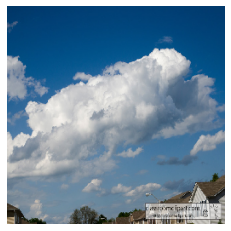

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# idをいろいろ入れ替えて、正解と予測を見比べてみましょう。
id = 10
plt.imshow(x_test[id]*255)
ans = int(y_test[id])
plt.axis('off')

target = x_test[id] # 単体の入力データを用意
predict_prob=model.predict(np.array([target]))
predict_class=int(np.round(predict_prob))

print(predict_class)
print('Truth: ', labels[ans], '\tPredicted: ', labels[predict_class])

### 4. ユーザーがアップロードした写真から、この後雨になるのか晴れになるのか予測する

Saving amagumoPAR51064_TP_V4.jpg to amagumoPAR51064_TP_V4.jpg
1/1 [==============================] - 0s 82ms/step
0
Predicted:  雨


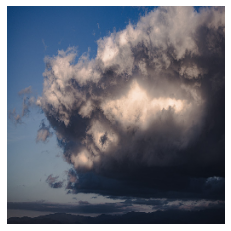

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np
model = load_model('/content/drive/MyDrive/keras_clouds_trained_model')
from google.colab import files
files = files.upload()
filename = list(files.keys())[0]

img_shape = (256, 256, 3)
temp_img = load_img(filename, grayscale=False, target_size=img_shape)#PIL形式で画像読み込み
temp_img_array = img_to_array(temp_img) / 255 #PIL⇒配列化 + 255で割って正規化


plt.imshow(temp_img_array)
plt.axis('off')
target = temp_img_array # 単体の入力データを用意
predict_prob=model.predict(np.array([target]))
predict_class=int(np.round(predict_prob))

print(predict_class)
print('Predicted: ', labels[predict_class])

空の写真に対して雨雲を認識してこれから雨が降ると予測できた

##振り返り

精度は8割程度だった。当てずっぽうで当てるよりかは精度は高いが、2値分類なのに精度があまり上がらなかった理由としては以下が考えられる。
スクレイピングにはとても時間がかかるので、学習データがそもそも大幅に不足している。
データの前処理を一切行っていないので、画像を見てみると関係ない画像も一部含まれている。

また、Fine-tuningや転移学習を用いればさらなる精度向上が見込まれるとは思うが、今回はあくまで教材コードを主に使うという条件があったため、CNNで一から学習させることにしました


参考にしたサイト：
https://qiita.com/ku_a_i/items/7f71933f6b71cf30a3a8

検証写真：https://www.pakutaso.com/20210202032post-33248.html